<h1>Housing Discrimination and Algorithmic Bias</h1>
<H2>Initial Investigation</H2>
<h3>By Abby Roberts</h3>

<h2>Import Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Import Data</h2>

In [2]:
df = pd.read_csv('../../Data/mortgage_covenant_data.csv')
df.head(2)

,activity_year,census_tract,derived_race,action_taken,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,covenant_density
0,2023,2.703706e+10,Race Not Available,6,185000.0,195000.0,NaN,6.125,40.37,73.48,10,0.0,False,NaN
1,2023,2.714103e+10,Race Not Available,6,375000.0,385000.0,NaN,6.625,10.64,121.26,10,0.0,False,NaN


In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100931 entries, 0 to 100930
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      100931 non-null  int64  
 1   census_tract                       99915 non-null   float64
 2   derived_race                       100931 non-null  object 
 3   action_taken                       100931 non-null  int64  
 4   loan_amount                        100931 non-null  float64
 5   property_value                     83491 non-null   float64
 6   income                             88200 non-null   float64
 7   interest_rate                      78125 non-null   float64
 8   tract_minority_population_percent  100931 non-null  float64
 9   tract_to_msa_income_percentage     100931 non-null  float64
 10  denial_reason-1                    100931 non-null  int64  
 11  covenant_count                     1009

<h3>Create categoricals</h3>

In [4]:
# will help with making sure items ordered correctly later
covenant_density_list = ['None (0)', 'Low (1-50)', 'Medium (51-100)', 'High (101-200)', 'Very High (>200)']
df['covenant_density'] = pd.Categorical(df['covenant_density'], covenant_density_list)

derived_race_list = np.sort(df['derived_race'].unique())
df['derived_race'] = pd.Categorical(df['derived_race'], derived_race_list)

In [5]:
list(np.sort(df['derived_race'].unique()))

['2 or more minority races',
 'American Indian or Alaska Native',
 'Asian',
 'Black or African American',
 'Free Form Text Only',
 'Joint',
 'Native Hawaiian or Other Pacific Islander',
 'Race Not Available',
 'White']

<h2>Investigate Data Bias</h2>

<h3>Property values in areas with/without historical covenants</h3>

In [6]:
df['covenant_density'] = df['covenant_density'].fillna('None (0)')

df['covenant_density'].value_counts()

covenant_density
None (0)            89762
Low (1-50)           4537
Very High (>200)     3140
Medium (51-100)      1772
High (101-200)       1720
Name: count, dtype: int64

In [7]:
df.groupby('covenant_density', observed=True).agg({'property_value': ['mean', 'median', 'min', 'max']})

property_value                                
                           mean    median      min          max
covenant_density                                               
None (0)          387560.383214  315000.0   5000.0  111325000.0
Low (1-50)        418831.701508  325000.0   5000.0    7625000.0
Medium (51-100)   567187.500000  365000.0  55000.0   48055000.0
High (101-200)    547739.916551  375000.0  55000.0   64405000.0
Very High (>200)  506902.255639  385000.0  25000.0   14205000.0

<h3>Neighborhood demographic and economic characteristics</h3>

In [8]:
df.groupby('covenant_density', observed=True).agg({'income': ['mean', 'median', 'min', 'max']})

income                           
                        mean median      min        max
covenant_density                                       
None (0)          147.222444   94.0  -1661.0  1651000.0
Low (1-50)        139.971892  100.0 -34157.0     6155.0
Medium (51-100)   168.160550  112.0      0.0     4824.0
High (101-200)    181.273954  117.0    -54.0    10415.0
Very High (>200)  184.480253  128.0      0.0     7303.0

In [9]:
df.groupby('covenant_density', observed=True).agg({'tract_minority_population_percent': ['mean', 'median', 'min', 'max']})

tract_minority_population_percent                     
                                              mean median    min    max
covenant_density                                                       
None (0)                                 21.940751  17.56   0.00  95.63
Low (1-50)                               37.501120  33.40   7.60  83.59
Medium (51-100)                          26.929069  20.80   6.93  62.20
High (101-200)                           24.150360  21.62  10.20  49.30
Very High (>200)                         25.431010  19.08   8.95  65.01

In [10]:
df[df['derived_race']!='Race Not Available'].groupby(['covenant_density', 'derived_race'], observed=True)['derived_race'].count()

covenant_density  derived_race                             
None (0)          2 or more minority races                       117
                  American Indian or Alaska Native               630
                  Asian                                         5361
                  Black or African American                     4522
                  Free Form Text Only                              5
                  Joint                                         2068
                  Native Hawaiian or Other Pacific Islander      101
                  White                                        56914
Low (1-50)        2 or more minority races                         7
                  American Indian or Alaska Native                34
                  Asian                                          264
                  Black or African American                      427
                  Joint                                          145
                  Native Hawaiian or Other 

<Axes: xlabel='covenant_density', ylabel='count'>

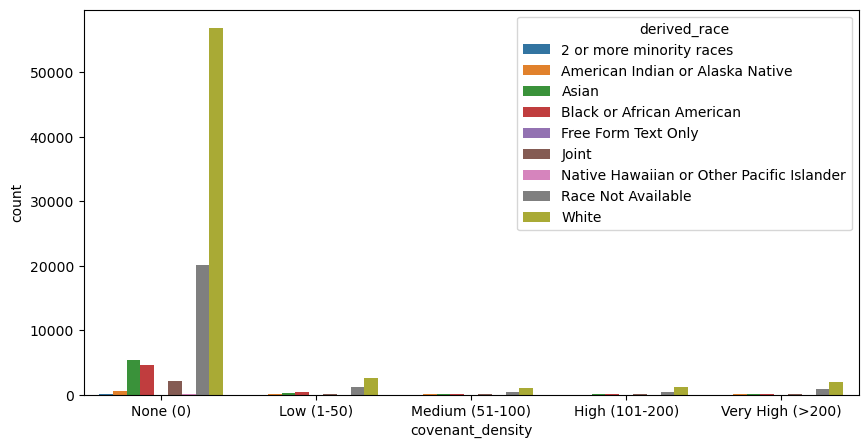

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(df, x='covenant_density', hue='derived_race')

<Axes: xlabel='covenant_density', ylabel='percent_group'>

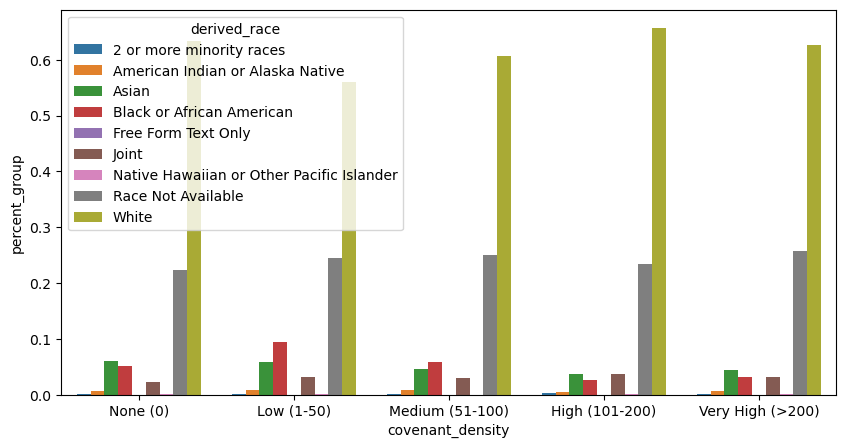

In [12]:
df_hist1 = df.groupby(['covenant_density', 'derived_race'], as_index=False, observed=True)['activity_year'].count()
df_hist1['overall_count'] = df_hist1.groupby('covenant_density', observed=True)['activity_year'].transform('sum')
df_hist1['percent_group'] = df_hist1['activity_year'] / df_hist1['overall_count']

plt.figure(figsize=(10, 5))
sns.barplot(df_hist1, x='covenant_density', hue='derived_race', y='percent_group')

<h3>Patterns of generational wealth and investment</h3>

Honestly, not sure how to track this one. Let me know if anyone else has something.

<h2>Algorithmic Bias</h2>

<h3>Mortgage approval rates and terms</h3>

In [13]:
df_approval_rate = df.groupby('covenant_density', observed=True).agg({'was_approved': ['count', 'sum']})['was_approved']
df_approval_rate['approval_rate'] = df_approval_rate['sum']/df_approval_rate['count']
df_approval_rate

,count,sum,approval_rate
covenant_density,,,
None (0),89762,59590,0.663867
Low (1-50),4537,3000,0.661230
Medium (51-100),1772,1188,0.670429
High (101-200),1720,1191,0.692442
Very High (>200),3140,2116,0.673885


In [14]:
df.groupby('covenant_density', observed=True).agg({'interest_rate': ['mean', 'median', 'min', 'max']})

interest_rate                    
                          mean  median  min    max
covenant_density                                  
None (0)              6.570505  6.6250  0.0  15.50
Low (1-50)            6.575339  6.7500  0.0  12.50
Medium (51-100)       6.614788  6.7500  0.0  10.95
High (101-200)        6.622736  6.6250  0.0  15.00
Very High (>200)      6.650657  6.6325  0.0  13.00

<h3>Risk assessment criteria</h3>

Honestly, not sure how to track this one. Let me know if anyone else has something.

<h3>The use of potentially biased proxy variables</h3>

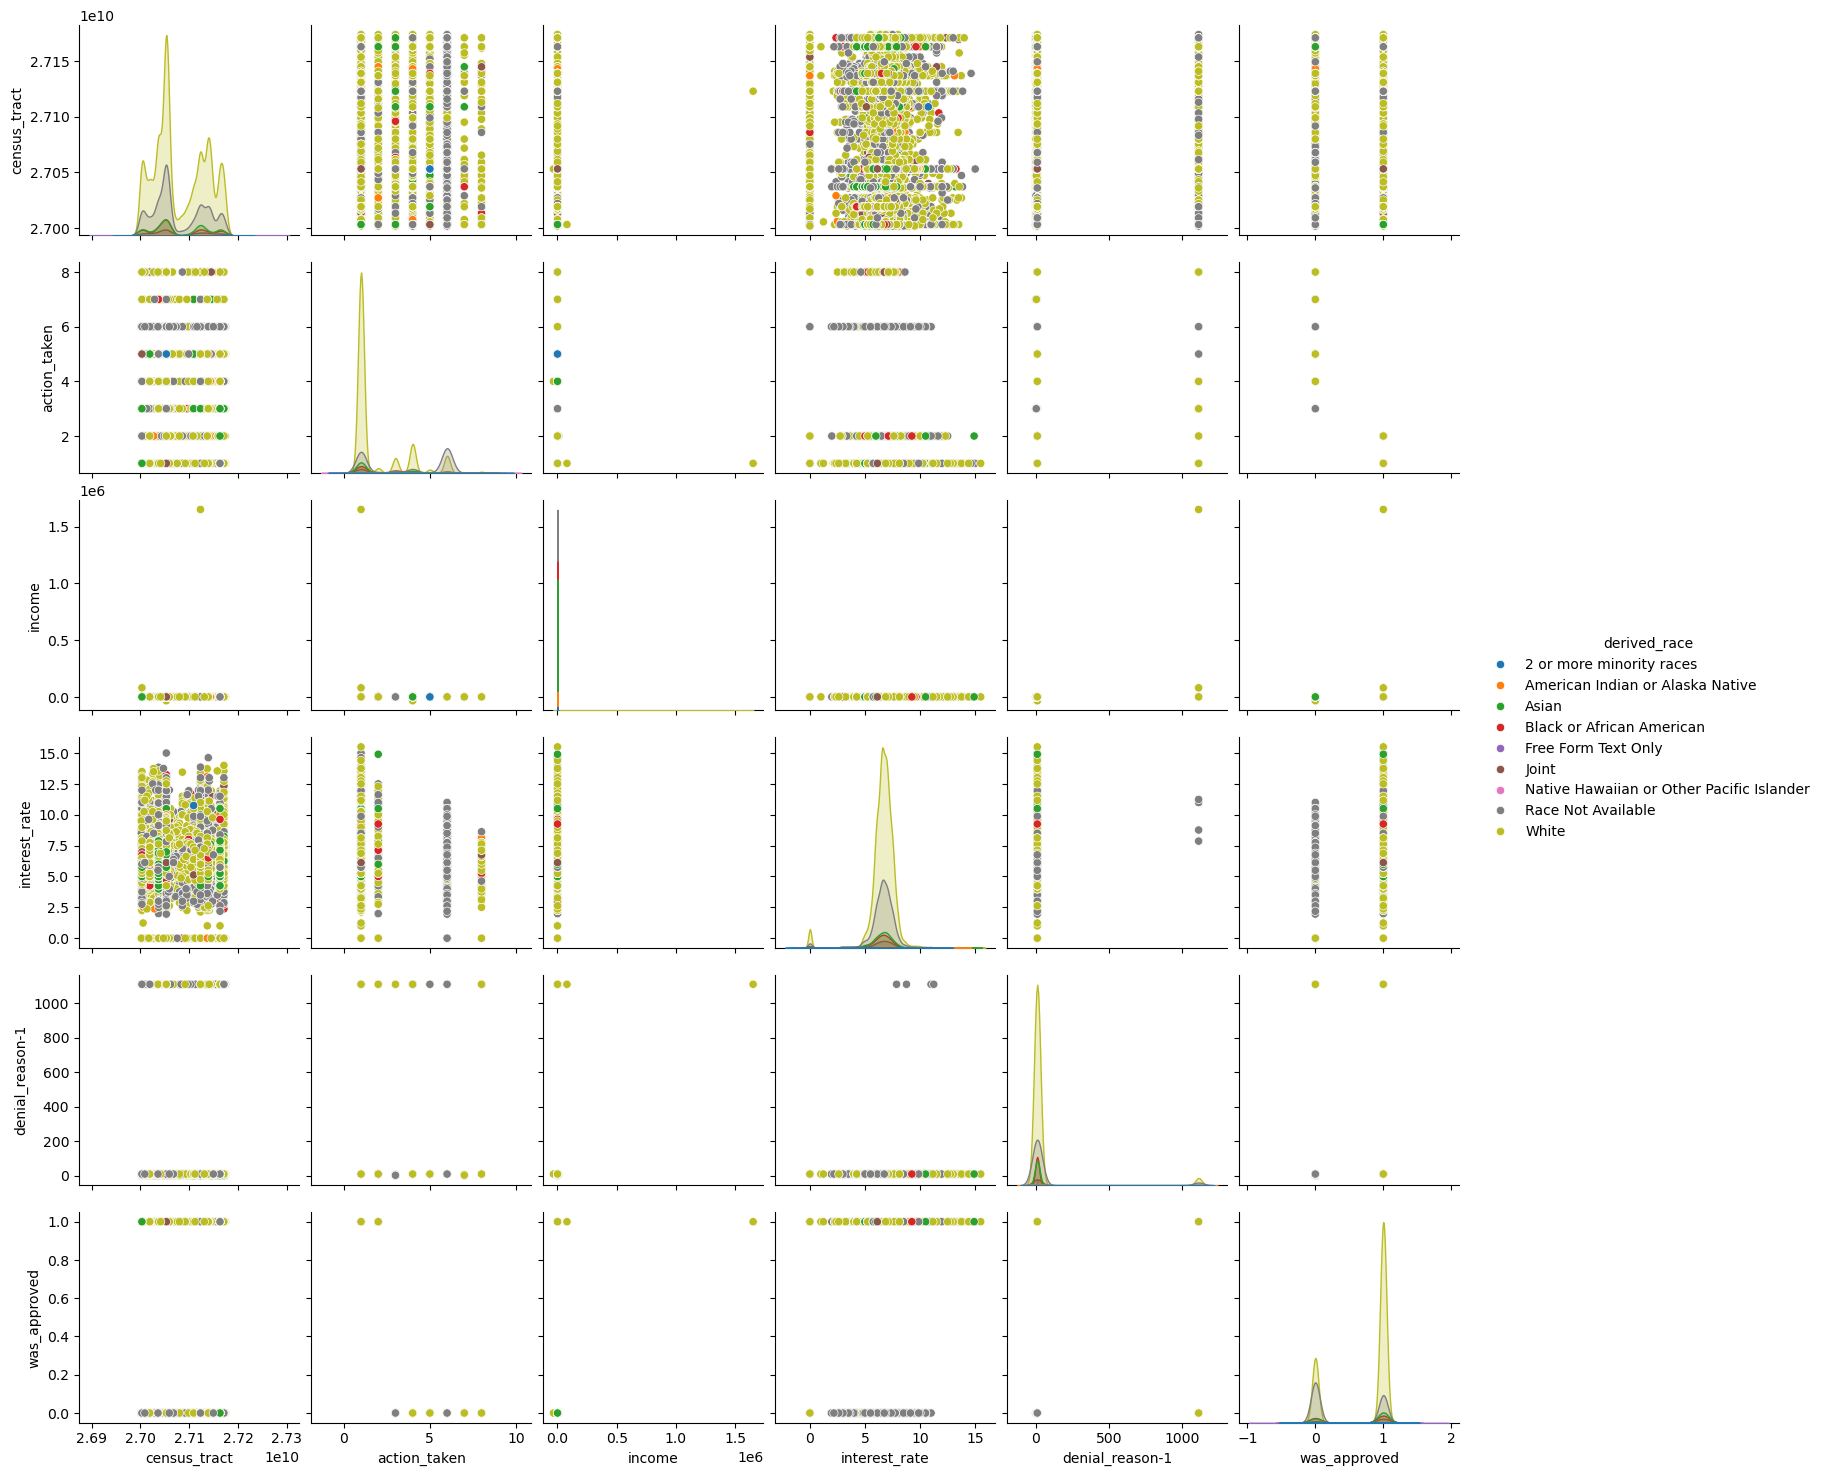

In [15]:
sns.pairplot(df[['census_tract', 'action_taken', 'income', 'interest_rate', 'denial_reason-1', 'was_approved', 'derived_race']],
            hue='derived_race')